<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-summary" data-toc-modified-id="Data-summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data summary</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-control-sets" data-toc-modified-id="Distributions-of-control-sets-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Distributions of control sets</a></span></li><li><span><a href="#ROC-AUCs" data-toc-modified-id="ROC-AUCs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ROC-AUCs</a></span></li></ul></li><li><span><a href="#Gene-level-analysis" data-toc-modified-id="Gene-level-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gene level analysis</a></span><ul class="toc-item"><li><span><a href="#Residual-z-scores" data-toc-modified-id="Residual-z-scores-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Residual z-scores</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text
from poola import core as pool
warnings.filterwarnings('ignore')
gpp.set_aesthetics(palette='Set2')


def get_controls(df):
    '''
    Input: df: data frame with 'Gene Symbol' column used to subset rows with 'NO_SITE' and 'ONE_INTERGENIC' controls
    Outputs: nosite: data frame with data for 'NO_SITE' controls 
             intergneic: data frame with data for 'ONE_INTERGENIC' controls 
    '''
    nosite = df[df['Gene Symbol'].str.contains('NO_SITE')]
    intergenic = df[df['Gene Symbol'].str.contains('ONE_INTERGENIC')] 
    return nosite, intergenic

def get_lognorm(df, col):
    '''
    Input: df: read counts data frame 
    col: column name corresponding to reads that will be log-normalized 
    Outputs: df: data frame with log-normalized columns 
    '''
    df[col+'_lognorm'] = np.log2(df[col]/df[col].sum()*1e6 +1)
    return df



In [2]:
import anchors
import statsmodels
from scipy import stats

def pair_cols(df, initial_id = 'ini', res_id = 'res', col_type = 'LFC'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    3. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    4. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    Outputs: 
    1. sharex: if number of pairs greater than 1 indicating multiple subplots
    2. pairs: pairs of initial and resistant populations as list of lists     
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        sharex = True # set sharex parameter for subplot 
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split('_')
                ini_index = split_col.index(initial_id)
                res_col_string = '_'.join(split_col[:ini_index])
                print(res_col_string)
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    screen_str = screen + ' ' + number 
                    #res_col_string = res_col_string + ' ' + screen_str
                    print(res_col_string)
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col)]# and (screen_str in col)]
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and ('screen' not in col)]
                    
                    #res_col_string = col.replace('initial', 'resistant')
                    #print(screres_col_string)
                #for col in cols: 
                #res_pop = [col for col in cols if (res_col_string in col) and ('resistant' in col)]
                print(res_pop)
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        return sharex, pairs
    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    '''
    paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    #print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def check_gene_inputs(guide_residuals, guide_mapping):
    """ Check that input dataframes have the right column names
    Parameters
    ----------
    guide_residuals: DataFrame
        Results from get_guide_residuals
    guide_mapping: DataFrame
        Mapping between guides and genes. The
        first column should identify sgRNAs and the second column should identify gene symbols
    Raises
    ------
    Value Error
        If the LFC dataframe doesn't have all of the columns in the reference df
    """
    if guide_mapping.shape[1] < 2:
        raise ValueError('Guide mapping dataframe needs at least two columns')
    mapping_construct_col = guide_mapping.columns[0]
    residual_construct_col = guide_residuals.columns[0]
    residual_constructs = guide_residuals[residual_construct_col].unique()
    guide_mapping_constructs = guide_mapping[mapping_construct_col].unique()
    if not (set(residual_constructs) <= set(guide_mapping_constructs)):
        raise ValueError('Guide mapping is missing guides from the residual dataframe')


def merge_residual_mapping(guide_residuals, guide_mapping, residual_construct_col, mapping_construct_col):
    """Join guide residual df and mapping to genes
    Parameters
    ----------
    guide_residuals: DataFrame
        Guide-level residuals
    guide_mapping: DataFrame
        Mapping between guides and genes
    residual_construct_col: str
        Name of column with constructs in the residual DataFrame
    mapping_construct_col: str
        Name of column with constructs in the guide/gene mapping file
    Returns
    -------
    DataFrame
        Guide residuals mapped to genes
    """
    mapped_guide_residuals = guide_residuals.merge(guide_mapping, how='inner',
                                                   left_on=residual_construct_col,
                                                   right_on=mapping_construct_col)
    return mapped_guide_residuals


import statsmodels
from anchors.score import aggregate_guide_residuals

def aggregate_guide_residuals(mapped_guide_residuals, gene_col, construct_col):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    mapped_guide_residuals: DataFrame
        Guide residuals mapped to genes
    gene_col: str
        Name of column with genes
    construct_col: str
        Name of column with constructs
    Returns
    -------
    DataFrame
        Gene summarized residuals
    """
    mapped_guide_residuals['lfc_reference']=pd.to_numeric(mapped_guide_residuals['lfc_reference'], errors='coerce')
    mapped_guide_residuals['lfc']=pd.to_numeric(mapped_guide_residuals['lfc'], errors='coerce')
    gene_residuals = (mapped_guide_residuals.groupby([gene_col])
                      .agg(sum_z=('residual_z', 'sum'),
                           guides=(construct_col, 'nunique'),
                           avg_lfc=('lfc', 'mean'),
                           avg_lfc_reference=('lfc_reference', 'mean'))
                      .reset_index())
    gene_residuals['residual_zscore'] = gene_residuals['sum_z'] / np.sqrt(gene_residuals['guides'])
    gene_residuals = gene_residuals.drop('sum_z', axis=1)
    gene_residuals['p_value'] = stats.norm.sf(abs(gene_residuals.residual_zscore)) * 2
    gene_residuals['fdr_bh'] = (gene_residuals.groupby('Gene Symbol')
                                .p_value
                                .transform(lambda x: statsmodels.stats.multitest.multipletests(x, method='fdr_bh')[1]))
    return gene_residuals

def get_gene_residuals(guide_residuals, guide_mapping):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    guide_residuals: DataFrame
        Results from get_guide_residuals
    guide_mapping: DataFrame
        Mapping between guides and genes. The
        first column should identify sgRNAs and the second column should identify gene symbols
    Returns
    -------
    """
    anchors.score.check_gene_inputs(guide_residuals, guide_mapping)
    mapping_construct_col = guide_mapping.columns[0]
    mapping_gene_col = guide_mapping.columns[1]
    residual_construct_col = guide_residuals.columns[0]
    mapped_guide_residuals = anchors.score.merge_residual_mapping(guide_residuals, guide_mapping, residual_construct_col,
                                                    mapping_construct_col)
    #print(mapped_guide_residuals)
    gene_residuals = aggregate_guide_residuals(mapped_guide_residuals, mapping_gene_col, residual_construct_col)
    return gene_residuals


In [3]:
def convertdftofloat(df):
    '''
    Converts df data column type into float 
    Input:
    1. df: data frame
    '''
    for col in df.columns[1:]:
        df[col] = df[col].astype(float) #convert dtype to float 
    return df

def new_rank_df(df, col = None, drop_col = True, ascending = False): #df with 2 cols "Gene Symbol" and scoring metric  
    '''
    Inputs:
    1. df: initial dataframe containing data that will be ranked
    2. col: column with data that will be ranked
    3. drop_col: bool indicating whether original data columns will be dropped in output df (default: True)
    4. ascending: direction of ranking (default: False)
    Output:
    rank_df: dataframe with ranked assigned to Gene Symbol 
    '''
    if not col:
        col = df.columns[1] #score column
    rank_df = pd.DataFrame()
    #print(col)
    rank_df = df.copy()[['Gene Symbol', col]]
    rank_df = df.sort_values(by = col, ascending = ascending).reset_index(drop = True) #column in descending order by default
    rank_col_name = 'Rank_' + col
    rank_df[rank_col_name] = rank_df.index + 1
    if drop_col: 
        rank_df = rank_df.copy().drop(col, axis = 1)
    rank_df = convertdftofloat(rank_df)
    return rank_df


def format_gene_residuals(df, guide_min = 3, guide_max = 5, conditions = []):
    '''
    Inputs: 
    1. df: gene_residuals output df 
    2. guide_min: min number of guides per gene to filter df
    3. guide_max: max number of guides per gene to filter df
    4. ascending: direction to sort df 
    Outputs:
    1. df_z: dataframe with the following columns: 
            -Gene Symbol
            -residual_zscore: residual_zscores averaged across conditions 
            -Rank_residual_zscore: 
    '''
    df = df[(df['guides']>=guide_min) & (df['guides']<=guide_max)]
#     df = df[df['p_value'].ne(0.0)]
    if 'condition' in df.columns: 
        conditions = list(set(df.loc[:, 'condition']))
        print(conditions)
        if len(conditions) > 1:
            df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
            condition_dict = {}
            for i, c in enumerate(conditions):
                print(c)
                condition_dict[c] = df_z[df_z['condition'] == c]
            #print(condition_dict) 
            merged_df_z = merge_dict_dfs(condition_dict, suffixes=['_x', '_y'])
            merged_df_z['residual_zscore_avg'] = merged_df_z.mean(axis = 1)
            #condition_cols = [col for col in merged_df_z.columns if 'condition' in col]
            df_z = merged_df_z.copy()[['Gene Symbol', 'residual_zscore_avg']]
            df_z = new_rank_df(df_z, 'residual_zscore_avg', drop_col=False)
    else:
        df_z = df[['Gene Symbol', 'residual_zscore']]
        df_z = new_rank_df(df_z, 'residual_zscore', drop_col=False)

    return df_z


## Data summary

* Cell line: Caco-2
* Library: Brunello

In [4]:
reads_plate1 = pd.read_csv('../Data/Reads/Goujon/Caco2/counts-JD_GPP1887_Goujon_Plate1.txt', sep ='\t')


In [5]:
bru_goujon_lfc = pd.read_csv('../Data/Interim/Goujon/Caco2/Brunello_pDNA_LFC_ann.txt', sep='\t')
Huh_cols = [col for col in bru_goujon_lfc.columns if 'Huh' in col]
Caco_lfc = bru_goujon_lfc.copy().drop(Huh_cols, axis =1)
Caco_lfc

,sgRNA Sequence,Caco2_1_ini_pop_LFC,Caco2_1_res_pop_LFC,Caco2_2.1_ini_pop_LFC,Caco2_2.1_res_pop_LFC,Barcode Sequence,Gene Symbol,Gene ID
0,AAAAAAAATCCGGACAATGG,-0.627596,-4.192756,-0.116111,-4.192756,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,0.329512,-2.425958,-0.336067,-4.127852,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,-0.809971,-4.041390,0.005114,-4.041390,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,0.188302,-2.930437,-0.026835,-2.930437,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,-0.734830,-3.388394,-0.177961,-3.388394,AAAAAACACAAGCAAGACCG,ZNF470,388566
...,...,...,...,...,...,...,...,...
87443,TTTTGACTCTAATCACCGGT,0.615543,-3.948733,0.014619,-4.319765,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,INACTIVE_4T_54
87444,TTTTTAATACAAGGTAATCT,0.311723,-3.304341,-0.038510,-4.142241,TTTTTAATACAAGGTAATCT,NO_SITE_940,NO_SITE_940
87445,TTTTTAATACAAGGTAATCT,0.311723,-3.304341,-0.038510,-4.142241,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,INACTIVE_5T_55
87446,TTTTTCTCACCCGATGAATC,-0.181965,-4.516670,0.126258,-4.516670,TTTTTCTCACCCGATGAATC,NO_SITE_941,NO_SITE_941


In [6]:
bru_nosite, bru_intergenic = get_controls(bru_goujon_lfc)

### Distributions of control sets 

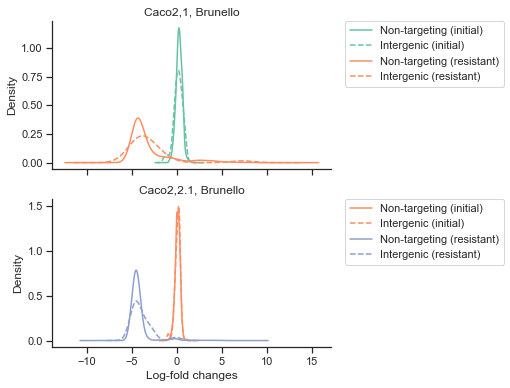

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols = [['Caco2_1_ini_pop_LFC','Caco2_1_res_pop_LFC'],['Caco2_2.1_ini_pop_LFC','Caco2_2.1_res_pop_LFC']]


for k,c in enumerate(cols):
    nosite_ini = bru_nosite[c[0]].plot(kind='kde',c=sns.color_palette('Set2')[i],label='Non-targeting (initial)', ax=ax[i], legend=True)
    inter_ini = bru_intergenic[c[0]].plot(kind='kde',c=sns.color_palette('Set2')[i],label='Intergenic (initial)', ax=ax[i], linestyle='--', legend=True)
    nosite_res = bru_nosite[c[1]].plot(kind='kde',c=sns.color_palette('Set2')[i+1],label='Non-targeting (resistant)', ax=ax[i], legend=True)
    inter_res = bru_intergenic[c[1]].plot(kind='kde',c=sns.color_palette('Set2')[i+1],label='Intergenic (resistant)', ax=ax[i], linestyle='--', legend=True)    
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])+', Brunello'
    t = ax[i].set_title(title)
    i+=1
    #handles = [nosite_ini, inter_ini, nosite_res, inter_res]
    # Put a legend to the right of the current axis
    #plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('../Figures/Caco2_control_distributions.png', bbox_inches="tight")

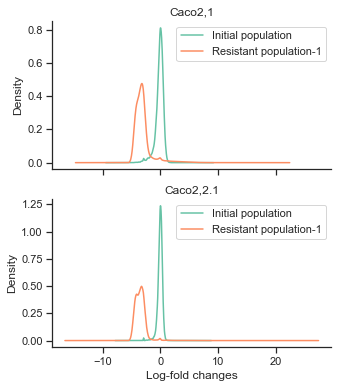

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols = [['Caco2_1_ini_pop_LFC','Caco2_1_res_pop_LFC'],['Caco2_2.1_ini_pop_LFC','Caco2_2.1_res_pop_LFC']]
for k,c in enumerate(cols):
    for l, c1 in enumerate(c):
        if l==0:
            label1 = 'Initial population'
        else:
            label1 = 'Resistant population-'+str(l)
        bru_goujon_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c1.split('_')[:2])
    t = ax[i].set_title(title)
    i+=1
    
fig.savefig('../Figures/Caco2_distributions.png', bbox_inches="tight")

In the Caco2-1 initial population, the intergenic controls are slightly more depleted than the non-targeting controls, with a t-test p-value of 0.09 but in the Caco2-2.1 and Huh7 initial populations, they are indistinguishable (p-values: 0.94 and 0.6). 

### ROC-AUCs
To further assess the activity of Cas9 in the Brunello screen, we calculated the ROC-AUCs for the 3 initial populations, Caco2_1, Caco2_2.1 and Huh7. The essential genes (defined by Hart et al., 2015) are considered to be true positives and the non-essential genes (defined by Hart et al., 2014) are false positives. The Caco2-1 initial population has the highest AUC showing higher Cas9 activity as compared to Caco2-2.1 and Huh7 populations. This is consistent with the observation made with the control sets. 

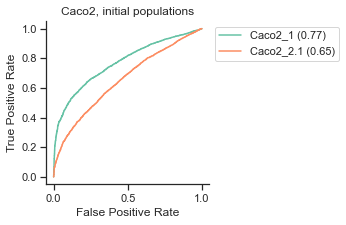

In [9]:
bru_caco2_1_df = pd.read_csv('../Data/Interim/Goujon/Caco2/Bru_caco1_ROC.txt', sep='\t')
bru_caco2_2_df = pd.read_csv('../Data/Interim/Goujon/Caco2/Bru_caco2_ROC.txt', sep='\t')

fig, ax = plt.subplots(figsize=(3,3))
g = plt.plot(bru_caco2_1_df.False_Positive_Rate, bru_caco2_1_df.True_Positive_Rate, label='Caco2_1 (0.77)')
g = plt.plot(bru_caco2_2_df.False_Positive_Rate, bru_caco2_2_df.True_Positive_Rate, label='Caco2_2.1 (0.65)')

t = plt.xlabel('False Positive Rate')
t = plt.ylabel('True Positive Rate')
t = plt.legend(bbox_to_anchor=(1,1))
t = plt.title('Caco2, initial populations', fontsize=12)
sns.despine()
ax.set_aspect('equal')
fig.savefig('../Figures/Caco2ROCAUC.png', bbox_inches = 'tight')

## Gene level analysis

### Residual z-scores

In [10]:
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(Caco_lfc)

Caco2_1
['Caco2_1_res_pop_LFC']
Caco2_2.1
['Caco2_2.1_res_pop_LFC']


In [11]:
Brunello_chip = pd.read_csv('../Data/Interim/Goujon/Caco2/CP0041_GRCh38_NCBI_strict_gene_20200612.chip', '\t')
Brunello_chip =  Brunello_chip.drop('Gene ID', axis = 1)
Brunello_chip = Brunello_chip.rename(columns = {'Barcode Sequence':'sgRNA Sequence'})
guide_mapping = pool.group_pseudogenes(Brunello_chip, pseudogene_size=4, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC', 'NO_SITE'])

In [12]:
gene_residuals = get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,A1BG,4,-2.699868,-0.002146,2.113965,0.034518,0.034518
1,A1CF,4,-3.763155,0.179752,-1.898438,0.057638,0.057638
2,A2M,4,-2.904729,0.021623,0.753404,0.451207,0.451207
3,A2ML1,4,-3.656228,-0.126825,-1.003935,0.315410,0.315410
4,A3GALT2,4,-3.595136,0.088162,-1.437913,0.150459,0.150459
...,...,...,...,...,...,...,...
21145,ZYG11A,4,-3.100714,-0.096630,1.430323,0.152624,0.152624
21146,ZYG11B,4,-3.530573,0.120227,-0.888804,0.374108,0.374108
21147,ZYX,4,-3.570887,0.069602,-0.923372,0.355813,0.355813
21148,ZZEF1,4,-4.270287,-0.245379,-2.882295,0.003948,0.003948


In [13]:
gene_residual_sheet = format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)
gene_residual_sheet

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'sgRNA Sequence', how = 'inner')
guide_residual_sheet

,sgRNA Sequence,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,SLC25A24,Caco2_1_res_pop_LFC,-0.946484,-0.636777,Caco2_1_ini_pop_LFC,-4.192756,-0.627596
1,AAAAAAAATCCGGACAATGG,SLC25A24,Caco2_2.1_res_pop_LFC,-0.632006,-0.665365,Caco2_2.1_ini_pop_LFC,-4.192756,-0.116111
2,AAAAAAAGGATGGTGATCAA,FASTKD3,Caco2_1_res_pop_LFC,0.557733,0.375232,Caco2_1_ini_pop_LFC,-2.425958,0.329512
3,AAAAAAAGGATGGTGATCAA,FASTKD3,Caco2_2.1_res_pop_LFC,-0.583487,-0.614285,Caco2_2.1_ini_pop_LFC,-4.127852,-0.336067
4,AAAAAAATGACATTACTGCA,BCAS2,Caco2_1_res_pop_LFC,-0.777184,-0.522875,Caco2_1_ini_pop_LFC,-4.04139,-0.809971
...,...,...,...,...,...,...,...,...
174891,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,Caco2_2.1_res_pop_LFC,-0.566381,-0.596276,Caco2_2.1_ini_pop_LFC,-4.142241,-0.03851
174892,TTTTTCTCACCCGATGAATC,NO_SITE_115,Caco2_1_res_pop_LFC,-1.339575,-0.901241,Caco2_1_ini_pop_LFC,-4.51667,-0.181965
174893,TTTTTCTCACCCGATGAATC,NO_SITE_115,Caco2_2.1_res_pop_LFC,-0.938762,-0.988313,Caco2_2.1_ini_pop_LFC,-4.51667,0.126258
174894,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Caco2_1_res_pop_LFC,-1.339575,-0.901241,Caco2_1_ini_pop_LFC,-4.51667,-0.181965


In [14]:
with pd.ExcelWriter('../Data/Processed/GEO_submission/Caco2_Brunello_Goujon.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Caco2_Brunello_avg_zscore', index =False)
    reads_plate1.to_excel(writer, sheet_name='Caco2_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Caco2_Brunello_guide_mapping', index =False)

In [16]:
with pd.ExcelWriter('../Data/Processed/Individual_screens/Caco2_Brunello_Goujon_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)